# 1. Алгоритм Apriori 

In [86]:
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [44]:
def get_frequent_sets(transactions, min_support, min_size):
    """ Метод для нахождения частых наборов по алгоритму Априори """
    transactions = [set(lst) for lst in transactions]

    item_count = {}

    for transaction in transactions:
        for item in transaction:
            item_count[item] = item_count.get(item, 0) + 1

    transactions_count = len(transactions)
    result_frequent_sets = {
        frozenset([item]): count for item, count in item_count.items()
        if count / transactions_count >= min_support
    }

    candidate_sets = generate_candidates_sets(result_frequent_sets.keys(), min_size)
    result_frequent_sets = {}
    while candidate_sets:
        item_count = {}

        for transaction in transactions:
            for candidate in candidate_sets:
                if candidate.issubset(transaction):
                    item_count[candidate] = item_count.get(candidate, 0) + 1

        candidate_sets = {
            itemset: count for itemset, count in item_count.items()
            if count / transactions_count >= min_support
        }

        result_frequent_sets.update(candidate_sets)

        min_size += 1

        candidate_sets = generate_candidates_sets(result_frequent_sets.keys(), min_size)

    return result_frequent_sets

In [45]:
def generate_candidates_sets(frequent_sets, set_size):
    """ Декартово произведение множества частых наборов на себя """
    candidates = set()
    sets_list = list(frequent_sets)
    for i in range(len(sets_list)):
        if set_size == 1: 
            candidates.add(sets_list[i])
            continue
        for j in range(i + 1, len(sets_list)):
            candidate = sets_list[i] | sets_list[j]
            if len(candidate) == set_size:
                candidates.add(candidate)

    return candidates

In [46]:
def calculate_apriori(transactions, min_support=0, min_size=1, order_by="support"):
    test_frequent_sets = get_frequent_sets(transactions=transactions, min_support=min_support, min_size=min_size)
    results_df = pd.DataFrame(
        [(tuple(sorted(itemset)), count, 0) for itemset, count in test_frequent_sets.items()],
        columns=['items_set', 'count', 'support']
    )
    results_df['support'] = results_df['count'] / len(transactions)

    match order_by:
        case 'support':
            results_df = results_df.sort_values(by='support', ascending=False)
        case 'word':
            results_df = results_df.sort_values(by='items_set')
    
    return results_df.reset_index(drop=True)

# 2. Поиск ассоциативных правил

In [104]:
def calculate_association_rules(data, min_support, min_confidence):
    result_items = calculate_apriori(transactions=baskets_transactions, min_support=min_support, min_size=1)
    temp_association_rules = []

    for _, row in result_items.iterrows():
        items_set = row['items_set']
        support = row['support']

        if len(items_set) < 2:
            continue

        for i, item in enumerate(items_set):
            consequents = item
            antecedents = list(items_set)
            antecedents.pop(i)
            antecedents = tuple(antecedents)
            consequents_support = result_items[result_items["items_set"] == antecedents].iloc[0]["support"]
            confidence = support / consequents_support
            if confidence < min_confidence:
                continue
            new_temp_rule_row = {"antecedents": antecedents, 'consequents': consequents, 'support': support, 'confidence': confidence}
            temp_association_rules.append(new_temp_rule_row)
    
    return pd.DataFrame(temp_association_rules, columns=['antecedents', 'consequents', 'support', 'confidence'])

def calculate_association_rules(transactions, min_support, min_confidence):
    # Преобразование в разряженную матрицу
    te = TransactionEncoder()
    te_transform = te.fit(transactions).transform(transactions)
    transactions_matrix = pd.DataFrame(te_transform, columns=te.columns_)
    frequent_itemsets = apriori(transactions_matrix, min_support=min_support, verbose=0, use_colnames=True)

    # Поиск ассоциативных правил
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    rules["antecedent"] = rules["antecedents"].apply(lambda x: ', '.join(list(x)))
    rules["consequent"] = rules["consequents"].apply(lambda x: ', '.join(list(x)))
    rules = rules[["antecedent", "consequent", "support", "confidence"]]

    frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
    rules = rules.sort_values(by='support', ascending=False)

    return frequent_itemsets, rules

# 3. Эксперименты с поиском ассоциативных правил

In [74]:
baskets = pd.read_csv('baskets.csv', encoding='windows-1251', header=None)
baskets.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
7496,сливочное масло,низкокалорийный майонез,свежий хлеб,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7497,гамбургер,замороженные овощи,яйца,картофель-фри,журнал,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7498,курица,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7499,эскалоп,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7500,яйца,замороженный смузи,йогурт,низкокалорийный йогурт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
baskets_transactions = [list(row.dropna()) for index, row in baskets.iterrows()]

In [92]:
# Проведем эксперименты
min_support = 0.002
min_confidence_values = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for min_confidence in min_confidence_values:
    frequent_itemsets, rules = calculate_association_rules(baskets_transactions, min_support, min_confidence)
    
    display(f'Порог достоверности: {min_confidence}')
    display(pd.DataFrame(frequent_itemsets))
    display(pd.DataFrame(rules))

       support                                           itemsets
0     0.033329                                          (авокадо)
1     0.008399                                       (аксессуары)
2     0.013198                                        (баклажаны)
3     0.011465                                            (батат)
4     0.006932                             (батончик без глютена)
...        ...                                                ...
2487  0.002133             (молоко, торт, яйца, минеральная вода)
2488  0.004133          (шоколад, молоко, яйца, минеральная вода)
2489  0.002400  (шоколад, яйца, оливковое масло, минеральная в...
2490  0.002400  (шоколад, растительное масло, яйца, минеральна...
2491  0.002133            (шоколад, торт, яйца, минеральная вода)

[2492 rows x 2 columns]
                                        antecedents         consequents  \
0                           (эскалоп, грибной соус)          (макароны)   
1                           (крас

'Порог достоверности: 0.7'

,support,itemsets
47,0.238368,(минеральная вода)
42,0.187975,(макароны)
110,0.179709,(яйца)
28,0.170911,(картофель-фри)
104,0.163845,(шоколад)
...,...,...
1968,0.002133,"(свежий хлеб, шоколад, картофель-фри)"
1961,0.002133,"(картофель-фри, пирожные, яйца)"
1958,0.002133,"(картофель-фри, оливковое масло, яйца)"
354,0.002133,"(говяжий фарш, соус для барбекю)"


,antecedent,consequent,support,confidence
0,"эскалоп, грибной соус",макароны,0.004266,0.744186
8,"молоко, суп, замороженные овощи",минеральная вода,0.003066,0.766667
10,"макароны, растительное масло, яйца",минеральная вода,0.003066,0.718750
9,"шоколад, оливковое масло, замороженные овощи",минеральная вода,0.002800,0.700000
12,"молоко, оливковое масло, яйца",минеральная вода,0.002666,0.714286
2,"макароны, обезжиренное молоко",минеральная вода,0.002533,0.730769
6,"говяжий фарш, креветки, замороженные овощи",макароны,0.002533,0.791667
4,"макароны, блинчики, растительное масло",минеральная вода,0.002266,0.739130
5,"макароны, блинчики, суп",минеральная вода,0.002266,0.772727
1,"красное вино, индейка",минеральная вода,0.002133,0.727273


       support                                           itemsets
0     0.033329                                          (авокадо)
1     0.008399                                       (аксессуары)
2     0.013198                                        (баклажаны)
3     0.011465                                            (батат)
4     0.006932                             (батончик без глютена)
...        ...                                                ...
2487  0.002133             (молоко, торт, яйца, минеральная вода)
2488  0.004133          (шоколад, молоко, яйца, минеральная вода)
2489  0.002400  (шоколад, яйца, оливковое масло, минеральная в...
2490  0.002400  (шоколад, растительное масло, яйца, минеральна...
2491  0.002133            (шоколад, торт, яйца, минеральная вода)

[2492 rows x 2 columns]
                                       antecedents         consequents  \
0                    (говяжий фарш, блинчики, рис)  (минеральная вода)   
1                        (макароны,

'Порог достоверности: 0.75'

,support,itemsets
47,0.238368,(минеральная вода)
42,0.187975,(макароны)
110,0.179709,(яйца)
28,0.170911,(картофель-фри)
104,0.163845,(шоколад)
...,...,...
1968,0.002133,"(свежий хлеб, шоколад, картофель-фри)"
1961,0.002133,"(картофель-фри, пирожные, яйца)"
1958,0.002133,"(картофель-фри, оливковое масло, яйца)"
354,0.002133,"(говяжий фарш, соус для барбекю)"


,antecedent,consequent,support,confidence
4,"молоко, суп, замороженные овощи",минеральная вода,0.003066,0.766667
2,"говяжий фарш, креветки, замороженные овощи",макароны,0.002533,0.791667
1,"макароны, блинчики, суп",минеральная вода,0.002266,0.772727
0,"говяжий фарш, блинчики, рис",минеральная вода,0.002133,0.842105
3,"помидоры, оливковое масло, замороженные овощи",макароны,0.002133,0.842105
5,"молоко, помидоры, рис",макароны,0.002133,0.800000


       support                                           itemsets
0     0.033329                                          (авокадо)
1     0.008399                                       (аксессуары)
2     0.013198                                        (баклажаны)
3     0.011465                                            (батат)
4     0.006932                             (батончик без глютена)
...        ...                                                ...
2487  0.002133             (молоко, торт, яйца, минеральная вода)
2488  0.004133          (шоколад, молоко, яйца, минеральная вода)
2489  0.002400  (шоколад, яйца, оливковое масло, минеральная в...
2490  0.002400  (шоколад, растительное масло, яйца, минеральна...
2491  0.002133            (шоколад, торт, яйца, минеральная вода)

[2492 rows x 2 columns]
                                       antecedents         consequents  \
0                    (говяжий фарш, блинчики, рис)  (минеральная вода)   
1  (помидоры, оливковое масло, замо

'Порог достоверности: 0.8'

,support,itemsets
47,0.238368,(минеральная вода)
42,0.187975,(макароны)
110,0.179709,(яйца)
28,0.170911,(картофель-фри)
104,0.163845,(шоколад)
...,...,...
1968,0.002133,"(свежий хлеб, шоколад, картофель-фри)"
1961,0.002133,"(картофель-фри, пирожные, яйца)"
1958,0.002133,"(картофель-фри, оливковое масло, яйца)"
354,0.002133,"(говяжий фарш, соус для барбекю)"


,antecedent,consequent,support,confidence
0,"говяжий фарш, блинчики, рис",минеральная вода,0.002133,0.842105
1,"помидоры, оливковое масло, замороженные овощи",макароны,0.002133,0.842105


       support                                           itemsets
0     0.033329                                          (авокадо)
1     0.008399                                       (аксессуары)
2     0.013198                                        (баклажаны)
3     0.011465                                            (батат)
4     0.006932                             (батончик без глютена)
...        ...                                                ...
2487  0.002133             (молоко, торт, яйца, минеральная вода)
2488  0.004133          (шоколад, молоко, яйца, минеральная вода)
2489  0.002400  (шоколад, яйца, оливковое масло, минеральная в...
2490  0.002400  (шоколад, растительное масло, яйца, минеральна...
2491  0.002133            (шоколад, торт, яйца, минеральная вода)

[2492 rows x 2 columns]
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, 

'Порог достоверности: 0.85'

,support,itemsets
47,0.238368,(минеральная вода)
42,0.187975,(макароны)
110,0.179709,(яйца)
28,0.170911,(картофель-фри)
104,0.163845,(шоколад)
...,...,...
1968,0.002133,"(свежий хлеб, шоколад, картофель-фри)"
1961,0.002133,"(картофель-фри, пирожные, яйца)"
1958,0.002133,"(картофель-фри, оливковое масло, яйца)"
354,0.002133,"(говяжий фарш, соус для барбекю)"


,antecedent,consequent,support,confidence


       support                                           itemsets
0     0.033329                                          (авокадо)
1     0.008399                                       (аксессуары)
2     0.013198                                        (баклажаны)
3     0.011465                                            (батат)
4     0.006932                             (батончик без глютена)
...        ...                                                ...
2487  0.002133             (молоко, торт, яйца, минеральная вода)
2488  0.004133          (шоколад, молоко, яйца, минеральная вода)
2489  0.002400  (шоколад, яйца, оливковое масло, минеральная в...
2490  0.002400  (шоколад, растительное масло, яйца, минеральна...
2491  0.002133            (шоколад, торт, яйца, минеральная вода)

[2492 rows x 2 columns]
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, 

'Порог достоверности: 0.9'

,support,itemsets
47,0.238368,(минеральная вода)
42,0.187975,(макароны)
110,0.179709,(яйца)
28,0.170911,(картофель-фри)
104,0.163845,(шоколад)
...,...,...
1968,0.002133,"(свежий хлеб, шоколад, картофель-фри)"
1961,0.002133,"(картофель-фри, пирожные, яйца)"
1958,0.002133,"(картофель-фри, оливковое масло, яйца)"
354,0.002133,"(говяжий фарш, соус для барбекю)"


,antecedent,consequent,support,confidence


       support                                           itemsets
0     0.033329                                          (авокадо)
1     0.008399                                       (аксессуары)
2     0.013198                                        (баклажаны)
3     0.011465                                            (батат)
4     0.006932                             (батончик без глютена)
...        ...                                                ...
2487  0.002133             (молоко, торт, яйца, минеральная вода)
2488  0.004133          (шоколад, молоко, яйца, минеральная вода)
2489  0.002400  (шоколад, яйца, оливковое масло, минеральная в...
2490  0.002400  (шоколад, растительное масло, яйца, минеральна...
2491  0.002133            (шоколад, торт, яйца, минеральная вода)

[2492 rows x 2 columns]
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, 

'Порог достоверности: 0.95'

,support,itemsets
47,0.238368,(минеральная вода)
42,0.187975,(макароны)
110,0.179709,(яйца)
28,0.170911,(картофель-фри)
104,0.163845,(шоколад)
...,...,...
1968,0.002133,"(свежий хлеб, шоколад, картофель-фри)"
1961,0.002133,"(картофель-фри, пирожные, яйца)"
1958,0.002133,"(картофель-фри, оливковое масло, яйца)"
354,0.002133,"(говяжий фарш, соус для барбекю)"


,antecedent,consequent,support,confidence


In [107]:
def show_graphics(data, min_support, min_confidence_values):
    # Список для хранения времени выполнения
    execution_times = []
    rule_counts = []
    for min_confidence in min_confidence_values:
        start_time = time.time()
        _, rules = calculate_association_rules(data, min_support, min_confidence)
        rule_counts.append(len(rules))
        execution_time = time.time() - start_time
        execution_times.append(execution_time)

    # Создаем диаграмму
    plt.figure(figsize=(10, 6))
    plt.plot(min_confidence_values, execution_times, marker='o')
    plt.xlabel('Порог достоверности')
    plt.ylabel('Время выполнения (сек)')
    plt.title('Сравнение быстродействия поиска правил при изменении порога достоверности')
    plt.grid(True)
    plt.show()

    # Создаем диаграмму
    plt.figure(figsize=(10, 6))
    plt.plot(min_confidence_values, rule_counts, marker='o')
    plt.xlabel('Порог достоверности')
    plt.ylabel('Количество правил')
    plt.title('Общее количество найденных правил при изменении порога достоверности')
    plt.grid(True)
    plt.show()

    
# Настройки для экспериментов
min_support = 0.002
min_confidence_values = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


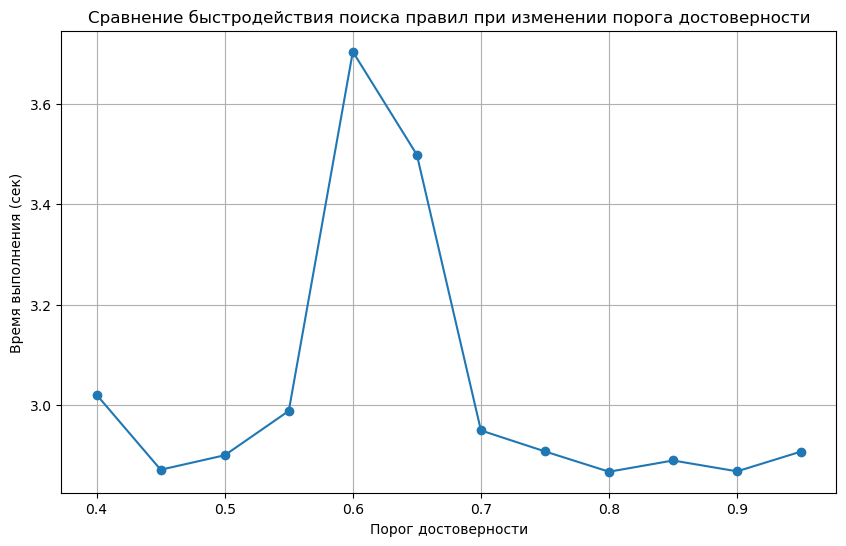

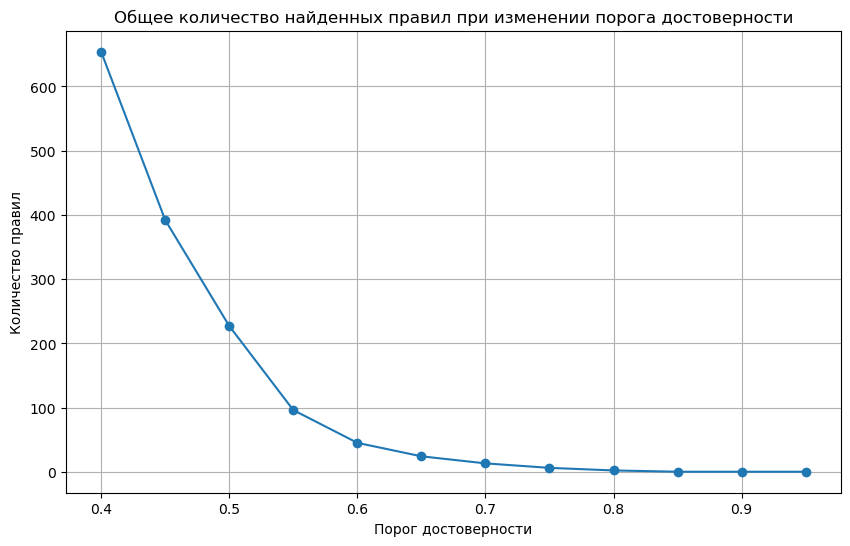

In [108]:
show_graphics(baskets_transactions, min_support, min_confidence_values)